# **Location Recommender System: Choosing the Best Neighborhood to Start Your Business in a Large City**
Capstone Project
***

# Introduction
Site selection is a strategic decision for a new business in a large city. Investors and business decision-makers need to consider different factors in searching for the right location(neighborhood) for their business. Budget limitations and the factors that directly affect the demand and the revenue of their products or services are among the most important factors in site selection. This project is designed to guide and inform investors and business decision-makers on suitable neighborhoods for their new business based on the number of competitors and the potential demand in each neighborhood. It is developed for businesses that rely on walk-ins and are suited for urban areas (such as restaurants, convenience stores, barbershops, ice cream shops, etc.). The potential demand for these businesses is highly affected by the type and number of nearby venues. Also, less competition in their neighborhood means a better chance for them to dominate the market and carve out a niche in that neighborhood.


To illustrate the system's performance, the case of opening an Ice Cream Shop in Boston is discussed and analyzed in this notebook. Further extension of this script will create an interface for the user to specify the business and the location(s) of interest (from a list of 25 US metropolitan cities) and a set of assumptions (competitors, type of nearby venues that increase their demand, the maximum number of competitors in a neighborhood, and search radius). The script will generate clusters of similar neighborhoods sorted by their average renting price, helping the business decision-maker for an informed site selection.

In [1]:
import numpy as np
import pandas as pd
from selenium import webdriver
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
import requests
from geopy.geocoders import Nominatim
import folium
import warnings
warnings.filterwarnings("ignore")

# Data sources for this project
## Scrape neighborhoods and their average rents from the Zumper website:
Used Selenium and BeautifulSoup libraries to scrape the average rent (1bed apt) in all neighborhoods of 25 large cities across the US (1,662 neighborhoods) (https://www.zumper.com/rent-research) 


In [2]:
url = "https://www.zumper.com/rent-research"
PATH= 'C:\Program Files (x86)\chromedriver.exe'
driver = webdriver.Chrome(PATH)
driver.get(url)

regions=['West','East','Midwest','South']

zumper_data=pd.DataFrame()
for i in regions:
    driver.find_element_by_xpath("//button[. = '"+i+"']").click()
    names = driver.find_elements_by_xpath("//div[@class='ReportCard_city__2o2n2']")
    cities_name = [x.text for x in names]
    links = driver.find_elements_by_xpath("//a[@class='ReportCard_card__2xqJ-']")
    cities_link = [x.get_attribute("href") for x in links]
    data={'region':[i]*len(cities_name),
         'city':cities_name,
         'link': cities_link }
    data= pd.concat({k: pd.Series(v) for k, v in data.items()}, axis=1)
    zumper_data=zumper_data.append(data, ignore_index=True)

driver.quit()
zumper_data['city']=zumper_data['city']+', USA'
zumper_data

,region,city,link
0,West,"Los Angeles, CA, USA",https://www.zumper.com/rent-research/los-angel...
1,West,"San Francisco, CA, USA",https://www.zumper.com/rent-research/san-franc...
2,West,"San Diego, CA, USA",https://www.zumper.com/rent-research/san-diego-ca
3,West,"Portland, OR, USA",https://www.zumper.com/rent-research/portland-or
4,West,"Seattle, WA, USA",https://www.zumper.com/rent-research/seattle-wa
5,West,"Sacramento, CA, USA",https://www.zumper.com/rent-research/sacrament...
6,West,"Phoenix, AZ, USA",https://www.zumper.com/rent-research/phoenix-az
7,West,"Denver, CO, USA",https://www.zumper.com/rent-research/denver-co
8,West,"Salt Lake City, UT, USA",https://www.zumper.com/rent-research/salt-lake...
9,East,"Washington, DC, USA",https://www.zumper.com/rent-research/washingto...


In [6]:
def address_correct(x):
    if ' - ' in x:
        x=x.split('-')[1]
    return x

all_data=pd.DataFrame()
for i in zumper_data.itertuples():
    city_name=i.city
    url=i.link
    source=requests.get(url).text
    # create a Beautiful Soup object from the html
    soup = BeautifulSoup(source,"lxml")
    ave_rent = soup.find('table', class_='NeighborhoodRent_table__2AiTW').tbody
    rows=ave_rent.find_all('tr')
    city_data=[]
    for row in rows:
        cols=row.find_all('td')
        cols=[i.region, city_name]+[ele.text.strip() for ele in cols]
        city_data.append([ele for ele in cols if ele]) # Get rid of empty values
    table_data=pd.DataFrame(city_data , columns=['Region','City','Neighborhood' , 'Average Rent'])
    table_data.Neighborhood=table_data.Neighborhood.apply(lambda addr: address_correct(addr))
    all_data=all_data.append(table_data, ignore_index=True)

# all_data
print ('The information of {0} neighborhoods of {1} cities across the US is collected.'.format(all_data.shape[0] , zumper_data.shape[0]) )  

The information of 1662 neighborhoods of 25 cities across the US is collected.


In [7]:
#extract neighborhoods of Boston
df_boston=all_data[all_data.City=='Boston, MA, USA']

## Use GeopPy to get the coordinates of the neighborhoods:
The latitude and the longitude coordinates of all the neighborhoods of Boston are collected.

In [12]:
geolocator = Nominatim(user_agent='myapplication')
    
Cols=['Neighborhood','City']
df_boston['Neighborhood'] = df_boston[Cols].apply(lambda row: ', '.join(row.values.astype(str)), axis=1)      
df_boston['latlon'] = df_boston['Neighborhood'].apply(lambda addr: geolocator.geocode(addr))
df_boston = df_boston[df_boston['latlon'].notna()] 
df_boston["Latitude"] = [x.latitude for x in df_boston['latlon'] if x is not None]
df_boston["Longitude"] = [x.longitude for x in df_boston['latlon'] if x is not None]
df_boston.reset_index(drop=True, inplace=True)
df_boston.drop('latlon', 1 , inplace= True)

df_boston.drop([18], inplace=True)
df_boston.to_csv('df-boston.csv')#save the dataframe
print('We are investigating {} neighborhoods of Boston.'.format (len(df_boston)))
df_boston

We are investigating 43 neighborhoods of Boston.


,Region,City,Neighborhood,Average Rent,Latitude,Longitude
0,East,"Boston, MA, USA","Kenmore , Boston, MA, USA","$2,200",42.348944,-71.095300
1,East,"Boston, MA, USA","Commonwealth, Boston, MA, USA","$1,700",42.352832,-71.073976
2,East,"Boston, MA, USA","Back Bay, Boston, MA, USA","$2,400",42.350549,-71.080311
3,East,"Boston, MA, USA","St. Elizabeth's, Boston, MA, USA","$1,750",42.348650,-71.147996
4,East,"Boston, MA, USA","Mission Hill, Boston, MA, USA","$1,850",42.332560,-71.103608
5,East,"Boston, MA, USA","South End, Boston, MA, USA","$2,540",42.341310,-71.077230
6,East,"Boston, MA, USA","Oak Square, Boston, MA, USA","$1,650",42.350881,-71.168080
7,East,"Boston, MA, USA","Beacon Hill, Boston, MA, USA","$2,195",42.358708,-71.067829
8,East,"Boston, MA, USA","North End, Boston, MA, USA","$1,978",42.365097,-71.054495
9,East,"Boston, MA, USA","West Broadway, Boston, MA, USA","$3,058",42.341022,-71.054255


**Map the neighborhoods of Boston:**

In [13]:
#get location of Boston to map the neighborhoods
address = 'BOSTON, MA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Boston are {}, {}.'.format(latitude, longitude))


The geograpical coordinate of Boston are 42.3602534, -71.0582912.


In [15]:
# create map of Boston using latitude and longitude values of the neighborhoods
import folium 
map_Boston = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_boston['Latitude'], df_boston['Longitude'], df_boston['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Boston)  
            
map_Boston

In [24]:
# create map of Boston using latitude and longitude values of the neighborhoods 
map_Boston = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_boston['Latitude'], df_boston['Longitude'], df_boston['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        popup=label,
        parse_html=False).add_to(map_Boston)  
            
map_Boston

## Use Foursquare API to get type and number of venues around these neighborhoods:

Looking for Movie Theater, Playground, Park, Garden, Water Park, General Entertainment, Stadium, Amphitheater, Aquarium, Street Art, Beach, Recreation Center, and Pedestrian Plaza venues within walking distance (500 meters) from each of these neighborhoods. These venues are places that many people usually visit them for entertainment and hence will have good demand for ice cream shop

In [25]:
import foursquare
CLIENT_ID = '1HABFONPEEOMT0AS2GVXPK53A4EO43AXRTJVN3B03CG3N3BE'
CLIENT_SECRET = '0CR2ZL5CZHLX5OSIIJRZCBPXGCC1TIS2HQ04CUYLFBFRBG1Q' 
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
fs = foursquare.Foursquare( CLIENT_ID, CLIENT_SECRET)
RADIUS = 500 #Limit results to venues within this many meters of the specified location

In [26]:
# Venue categories to search around each neighborhood
# The list of all venue categories of FourSquare can be found in the following link: https://developer.foursquare.com/docs/resources/categories. 

fs_categories = {
    
    'Movie Theater': '4bf58dd8d48988d17f941735',
    'Playground': '4bf58dd8d48988d1e7941735',
    'Park': '4bf58dd8d48988d163941735',
    'Garden': '4bf58dd8d48988d15a941735',
    'Water Park': '4bf58dd8d48988d193941735',
    'General Entertainment': '4bf58dd8d48988d1f1931735',
    'Stadium' : '4bf58dd8d48988d184941735',
    'Amphitheater' :'56aa371be4b08b9a8d5734db',
    'Aquarium' : '4fceea171983d5d06c3e9823',
    'Street Art' : '52e81612bcbc57f1066b79ee',
    'Beach' : '4bf58dd8d48988d1e2941735',
    'Recreation Center' : '52e81612bcbc57f1066b7a26',
    'Pedestrian Plaza': '52e81612bcbc57f1066b7a25'
}

', ' .join([ cat for cat in fs_categories])

'Movie Theater, Playground, Park, Garden, Water Park, General Entertainment, Stadium, Amphitheater, Aquarium, Street Art, Beach, Recreation Center, Pedestrian Plaza'

In [27]:
# Define a function to search nearby venues for the categories specified and convert the result as dataframe
def venues_nearby(latitude, longitude, category, verbose=True):    
    results = fs.venues.search(
        params = {
            'query': category, 
            'll': '{},{}'.format(latitude, longitude),
            'radius': RADIUS,
            'categoryId': fs_categories[category]
        }
    )    
    df = json_normalize(results['venues'])
    cols = ['Name','Latitude','Longitude']    
    if( len(df) == 0 ):        
        df = pd.DataFrame(columns=cols)
    else:        
        df = df[['name','location.lat','location.lng']]
        df.columns = cols
    if( verbose ):
        print('{} "{}" venues are found within {}m of location'.format(len(df), category, RADIUS))
    return df

In [29]:
# to check the spesified venue categories for all the neighborhoods
from pathlib import Path

venues_csv = Path('./boston_venues.csv')
df_venues = None

# check the venues data is explored and downloaded 
if( venues_csv.exists() ):
    df_venues = pd.read_csv('./boston_venues.csv')
else:    
    # construct a dataframe to store data
    df_venues = pd.DataFrame(columns=[ 'Category','Latitude', 'Longitude'])
    for (region, city, name, average_rent, latitude, longitude) in df_boston.itertuples(index=False):
        for cat, cat_id in fs_categories.items():
            df = venues_nearby(latitude, longitude, cat, verbose=False)
            df['Neighborhood'] = name
            df['Average Rent'] = average_rent
            df['Category'] = cat
            df_venues = df_venues.append(df, sort=True)
    df_venues.to_csv('boston_venues.csv', index=False)

print('In total, {} venues are found in Boston.'.format(len(df_venues)))

# df_venues.head()

In total, 340 venues are found in Boston.


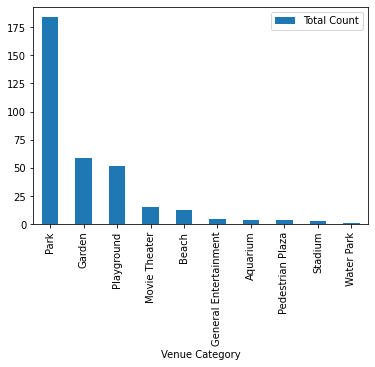

In [30]:
#number of venues from each category
import matplotlib.pyplot as plt
p= df_venues['Category'].value_counts().to_frame(name='Total Count')
p.index.name = 'Venue Category'
p.plot.bar(y='Total Count')

In [31]:
# number of venues for each neighborhood
df_groupby= df_venues.groupby('Neighborhood').count().reset_index()

In [32]:
#the dataset of all the venues from different categories in each neighborhood
boston_onehot = pd.get_dummies(df_venues[['Category']], prefix="", prefix_sep="")#one hot encoding
boston_onehot['Neighborhood'] = df_venues['Neighborhood'] 
fixed_columns = [boston_onehot.columns[-1]] + list(boston_onehot.columns[:-1])
boston_onehot = boston_onehot[fixed_columns]
# boston_onehot.head()

In [33]:
# Group rows by neighborhood to compare the frequency of different venue categories in each neighborhood: 
boston_grouped = boston_onehot.groupby('Neighborhood').sum().reset_index()
# boston_grouped

In [34]:
#neighborhoods without any 'Movie Theater, Playground, Park, Garden, Zoo, Water Park, General Entertainment, Stadium'venues: 
print('We will remove {} from the investigation as does not have any Movie Theater, Playground, Park, Garden, Water Park, General Entertainment, Stadium, Amphitheater, Aquarium, Street Art, Beach, Recreation Center, Pedestrian Plaza venues around.'
      .format(set(df_boston['Neighborhood']).difference(boston_grouped['Neighborhood'])))

We will remove {'Ashmont, Boston, MA, USA', 'Wellington Hill, Boston, MA, USA'} from the investigation as does not have any Movie Theater, Playground, Park, Garden, Water Park, General Entertainment, Stadium, Amphitheater, Aquarium, Street Art, Beach, Recreation Center, Pedestrian Plaza venues around.


In [35]:
### sort venues for each neighborhood
for hood in boston_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = boston_grouped[boston_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(int)
    temp = temp.round({'freq': 0})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True))
    print('\n')

---- Airport, Boston, MA, USA----
                   venue  freq
0                   Park     5
1             Playground     1
2                Stadium     1
3               Aquarium     0
4                  Beach     0
5                 Garden     0
6  General Entertainment     0
7          Movie Theater     0
8       Pedestrian Plaza     0
9             Water Park     0


---- Andrew Square, Boston, MA, USA----
                   venue  freq
0                   Park     3
1                Stadium     1
2               Aquarium     0
3                  Beach     0
4                 Garden     0
5  General Entertainment     0
6          Movie Theater     0
7       Pedestrian Plaza     0
8             Playground     0
9             Water Park     0


---- Beach Street, Boston, MA, USA----
                   venue  freq
0                   Park     9
1          Movie Theater     4
2               Aquarium     1
3                 Garden     1
4       Pedestrian Plaza     1
5             P

                   venue  freq
0                   Park     7
1                 Garden     3
2                  Beach     1
3             Playground     1
4               Aquarium     0
5  General Entertainment     0
6          Movie Theater     0
7       Pedestrian Plaza     0
8                Stadium     0
9             Water Park     0


----Highland Park, Boston, MA, USA----
                   venue  freq
0                   Park     5
1                 Garden     2
2             Playground     1
3               Aquarium     0
4                  Beach     0
5  General Entertainment     0
6          Movie Theater     0
7       Pedestrian Plaza     0
8                Stadium     0
9             Water Park     0


----Meeting House Hill, Boston, MA, USA----
                   venue  freq
0                 Garden     1
1                   Park     1
2               Aquarium     0
3                  Beach     0
4  General Entertainment     0
5          Movie Theater     0
6       Pedest

In [36]:
#a function to sort the venues in decrising order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [37]:
#find top 5 most common venues around each neighborhood
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues

columns =[ 'Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)

neighborhoods_venues_sorted['Neighborhood'] = boston_grouped['Neighborhood']


for ind in np.arange(boston_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(boston_grouped.iloc[ind, :], num_top_venues)

#neighborhoods_venues_sorted['Average Rent'] = df_boston_nj['Average Rent']
neighborhoods_venues_sorted['# of venues']= df_groupby['Category']

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,# of venues
0,"Airport, Boston, MA, USA",Park,Stadium,Playground,Water Park,Pedestrian Plaza,7
1,"Andrew Square, Boston, MA, USA",Park,Stadium,Water Park,Playground,Pedestrian Plaza,4
2,"Beach Street, Boston, MA, USA",Park,Movie Theater,Playground,Pedestrian Plaza,Garden,17
3,"Bunker Hill, Boston, MA, USA",Playground,Garden,Water Park,Stadium,Pedestrian Plaza,3
4,"Kenmore , Boston, MA, USA",Garden,Park,Stadium,Water Park,Playground,6
5,"Leather District, Boston, MA, USA",Park,Pedestrian Plaza,Movie Theater,Garden,Aquarium,14
6,"Mount Hope, Boston, MA, USA",Park,Garden,Water Park,Stadium,Playground,4
7,"Orient Heights, Boston, MA, USA",Playground,Park,Beach,Water Park,Stadium,3
8,"Paris Street, Boston, MA, USA",Park,Water Park,Stadium,Playground,Pedestrian Plaza,5
9,"Pond, Boston, MA, USA",Park,Garden,Pedestrian Plaza,Water Park,Playground,24


**Looking for Ice Cream and Frozen Yogurt shops within walking distance (500 meters) of each of the neighborhoods to get an understanding of the competitors in each neighborhood:**

In [38]:
# Ice cream shop and Frozen Yogurt Shop categories in FourSquare
fs_categories = {
    'Ice Cream Shop': ' 4bf58dd8d48988d1c9941735',
    'Frozen Yogurt Shop' : '512e7cae91d4cbb4e5efe0af'
}

In [39]:
# check Ice cream shop and Frozen Yogurt Shop venues around all the neighborhoods
from pathlib import Path

venues_csv = Path('./boston_ic_cream.csv')
df_venues = None
if( venues_csv.exists() ):
    df_venues = pd.read_csv('./boston_ic_creams.csv')
else:    
    # construct a dataframe to store data
    df_venues = pd.DataFrame(columns=[ 'Category','Latitude', 'Longitude'])
    for (region, city , name, average_rent, latitude, longitude) in df_boston.itertuples(index=False):
        for cat, cat_id in fs_categories.items():
            df = venues_nearby(latitude, longitude, cat, verbose=False)
            df['Neighborhood'] = name
            df['Average Rent'] = average_rent
            df['Category'] = cat
            df_venues = df_venues.append(df, sort=True)
    df_venues.to_csv('boston__ic_cream.csv', index=False)
   
print('Total {} Ice Cream and Frozen Yogurt Shops are found in Boston Area.'.format(len(df_venues)))

Total 37 Ice Cream and Frozen Yogurt Shops are found in Boston Area.


In [40]:
#number of Ice cream and Frozen Yogurt shops within walking distance of each of the neighborhoods
boston_onehot_ic = pd.get_dummies(df_venues[['Category']], prefix="", prefix_sep="")#one hot encoding
boston_onehot_ic['Neighborhood'] = df_venues['Neighborhood'] # add neighborhood column back to dataframe
fixed_columns = [boston_onehot_ic.columns[-1]] + list(boston_onehot_ic.columns[:-1])
boston_onehot_ic = boston_onehot_ic[fixed_columns]
boston_grouped_ic = boston_onehot_ic.groupby('Neighborhood').sum().reset_index()
boston_icecreamshops = pd.merge(df_boston, boston_grouped_ic, on=['Neighborhood'], how='outer').fillna(0)
boston_icecreamshops 

,Region,City,Neighborhood,Average Rent,Latitude,Longitude,Frozen Yogurt Shop,Ice Cream Shop
0,East,"Boston, MA, USA","Kenmore , Boston, MA, USA","$2,200",42.348944,-71.095300,0.0,4.0
1,East,"Boston, MA, USA","Commonwealth, Boston, MA, USA","$1,700",42.352832,-71.073976,0.0,1.0
2,East,"Boston, MA, USA","Back Bay, Boston, MA, USA","$2,400",42.350549,-71.080311,0.0,1.0
3,East,"Boston, MA, USA","St. Elizabeth's, Boston, MA, USA","$1,750",42.348650,-71.147996,0.0,0.0
4,East,"Boston, MA, USA","Mission Hill, Boston, MA, USA","$1,850",42.332560,-71.103608,0.0,1.0
5,East,"Boston, MA, USA","South End, Boston, MA, USA","$2,540",42.341310,-71.077230,0.0,0.0
6,East,"Boston, MA, USA","Oak Square, Boston, MA, USA","$1,650",42.350881,-71.168080,0.0,0.0
7,East,"Boston, MA, USA","Beacon Hill, Boston, MA, USA","$2,195",42.358708,-71.067829,0.0,3.0
8,East,"Boston, MA, USA","North End, Boston, MA, USA","$1,978",42.365097,-71.054495,0.0,3.0
9,East,"Boston, MA, USA","West Broadway, Boston, MA, USA","$3,058",42.341022,-71.054255,0.0,0.0


In [41]:
#add the number of ice cream and Frozen Yogurt shops to the dataframe of all the neighborhoods with the list of 5 most common venues
df_neighborhoods = pd.merge(neighborhoods_venues_sorted, boston_icecreamshops, on=['Neighborhood'], how='inner')
# df_neighborhoods

# Methodology

To select neighborhoods with fewer competitors, we will remove the neighborhoods with more than one ice cream and Frozen Yogurt shop. We will use K-means clustering to classify the neighborhoods based on the nearby venues and their frequencies (except the ice cream and Frozen Yogurt categories). To decide, we will sort the neighborhoods in each cluster based on their average rent price. A neighborhood with multiple venues, no ice cream shop and/or  Frozen Yogurt shop, and a lower renting price will be the best option.

## Select neighborhoods with fewer competitors
We remove neighborhoods with more than one ice cream or frozen yogurt shop:

In [42]:
low_competitor=df_neighborhoods[df_neighborhoods['Ice Cream Shop'] +df_neighborhoods['Frozen Yogurt Shop']< 2]
# low_competitor

## Cluster the neighborhoods: 
Run k-means to cluster the neighborhood into 5 clusters based on the frequency of different venue categories (except ice-cream shop and frozen yogurt shop) around them

In [43]:
# different categories for neighborhoods with less than 2 ice-cream and Frozen Yogurt Shop shops
boston_grouped_reduced= boston_grouped[boston_grouped.index.isin(low_competitor.index)]
# boston_grouped_reduced

In [44]:
from sklearn.cluster import KMeans
kclusters = 5 # set number of clusters

boston_grouped_clustering = boston_grouped_reduced.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(boston_grouped_clustering)

# find cluster labels generated for each row of boston_grouped dataframe (neghborhoods of boston excep Jamaica Plain and Mattapan)
kmeans.labels_[0:15] 

array([2, 2, 1, 2, 1, 2, 0, 1, 2, 1, 1, 0, 3, 1, 1])

In [45]:
#to add the clusters to the dataframe
low_competitor.insert(0, 'Cluster Label', kmeans.labels_)# add clustering labels

In [47]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
boston_merged = pd.merge(df_boston, low_competitor, on=['Region', 'City','Neighborhood', 'Average Rent','Latitude','Longitude'], how='inner')
# boston_merged

## Map the clustered neighborhoods

In [48]:
#visualize the clustered neighborhoods of boston
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# Matplotlib and associated plotting modules
import folium 
from folium.features import CustomIcon
from folium.plugins import MarkerCluster
import matplotlib.cm as cm
import matplotlib.colors as colors

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(boston_merged['Latitude'], boston_merged['Longitude'], boston_merged['Neighborhood'], boston_merged['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [49]:
im1 = map_clusters.save("map_clusters.jpg") 

# Results
The result of 5 clusters are specified in this section. The neighborhoods in each cluster are sorted based on their average rent price:

In [50]:
from re import sub
from decimal import Decimal

boston_merged['Average Rent']=boston_merged['Average Rent'].apply(lambda x: Decimal(sub(r'[^\d.]', '', x)))

 **Cluster 1:**

In [51]:
cluster1= boston_merged.loc[boston_merged['Cluster Label'] == 0]
cluster1

,Region,City,Neighborhood,Average Rent,Latitude,Longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,# of venues,Frozen Yogurt Shop,Ice Cream Shop
0,East,"Boston, MA, USA","Commonwealth, Boston, MA, USA",1700,42.352832,-71.073976,0,Park,Garden,Playground,Beach,Water Park,11,0.0,1.0
1,East,"Boston, MA, USA","Back Bay, Boston, MA, USA",2400,42.350549,-71.080311,0,Garden,Park,Playground,General Entertainment,Water Park,9,0.0,1.0
3,East,"Boston, MA, USA","Mission Hill, Boston, MA, USA",1850,42.332560,-71.103608,0,Park,Playground,Garden,Water Park,Stadium,13,0.0,1.0
10,East,"Boston, MA, USA","Highland Park, Boston, MA, USA",2025,42.325187,-71.094974,0,Park,Garden,Playground,Water Park,Stadium,8,0.0,1.0
14,East,"Boston, MA, USA","City Point, Boston, MA, USA",2250,42.336209,-71.028661,0,Park,Playground,Beach,Garden,Water Park,12,0.0,0.0
25,East,"Boston, MA, USA","River Street, Boston, MA, USA",1800,42.361390,-71.116270,0,Park,Garden,Playground,Water Park,Stadium,8,0.0,0.0
32,East,"Boston, MA, USA","Georgetown, Boston, MA, USA",1600,42.351854,-71.074830,0,Park,Garden,Playground,Beach,Water Park,12,0.0,1.0


In [52]:
cluster1= boston_merged.loc[boston_merged['Cluster Label'] == 0]
cols = [0,1,2,3,7,8,9,10,11,12,13,14]
cluster1[cluster1.columns[cols]].sort_values(['Average Rent'], ascending=True) #sort the neighborhoods in the cluster based on their average rent

,Region,City,Neighborhood,Average Rent,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,# of venues,Frozen Yogurt Shop,Ice Cream Shop
32,East,"Boston, MA, USA","Georgetown, Boston, MA, USA",1600,Park,Garden,Playground,Beach,Water Park,12,0.0,1.0
0,East,"Boston, MA, USA","Commonwealth, Boston, MA, USA",1700,Park,Garden,Playground,Beach,Water Park,11,0.0,1.0
25,East,"Boston, MA, USA","River Street, Boston, MA, USA",1800,Park,Garden,Playground,Water Park,Stadium,8,0.0,0.0
3,East,"Boston, MA, USA","Mission Hill, Boston, MA, USA",1850,Park,Playground,Garden,Water Park,Stadium,13,0.0,1.0
10,East,"Boston, MA, USA","Highland Park, Boston, MA, USA",2025,Park,Garden,Playground,Water Park,Stadium,8,0.0,1.0
14,East,"Boston, MA, USA","City Point, Boston, MA, USA",2250,Park,Playground,Beach,Garden,Water Park,12,0.0,0.0
1,East,"Boston, MA, USA","Back Bay, Boston, MA, USA",2400,Garden,Park,Playground,General Entertainment,Water Park,9,0.0,1.0


 **Cluster 2:**

In [53]:
cluster2=boston_merged.loc[boston_merged['Cluster Label'] == 1]
cluster2[cluster2.columns[cols]].sort_values(['Average Rent'], ascending=True) #sort the neighborhoods in the cluster based on their average rent

,Region,City,Neighborhood,Average Rent,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,# of venues,Frozen Yogurt Shop,Ice Cream Shop
21,East,"Boston, MA, USA","Meeting House Hill, Boston, MA, USA",800,Park,Garden,Water Park,Stadium,Playground,2,1.0,0.0
23,East,"Boston, MA, USA","Fields Corner West, Boston, MA, USA",1525,Playground,Park,Water Park,Stadium,Pedestrian Plaza,2,1.0,0.0
30,East,"Boston, MA, USA","Bellevue Hill, Boston, MA, USA",1550,Park,Water Park,Stadium,Playground,Pedestrian Plaza,1,0.0,0.0
17,East,"Boston, MA, USA","Orient Heights, Boston, MA, USA",1600,Playground,Park,Beach,Water Park,Stadium,3,0.0,0.0
20,East,"Boston, MA, USA","Woodbourne, Boston, MA, USA",1625,Playground,Park,Garden,Water Park,Stadium,4,0.0,0.0
5,East,"Boston, MA, USA","Oak Square, Boston, MA, USA",1650,Park,Playground,Beach,Water Park,Stadium,4,0.0,0.0
31,East,"Boston, MA, USA","West Roxbury Center, Boston, MA, USA",1700,Playground,Water Park,Stadium,Pedestrian Plaza,Park,1,0.0,0.0
28,East,"Boston, MA, USA","Fields Corner East, Boston, MA, USA",1750,Playground,Park,Water Park,Stadium,Pedestrian Plaza,2,1.0,0.0
27,East,"Boston, MA, USA","Readville, Boston, MA, USA",1800,Playground,Water Park,Stadium,Pedestrian Plaza,Park,1,0.0,0.0
26,East,"Boston, MA, USA","Dorchester, Boston, MA, USA",2046,Garden,Park,Water Park,Stadium,Playground,3,0.0,0.0


**Cluster 3:**

In [54]:
cluster3=boston_merged.loc[boston_merged['Cluster Label'] == 2]
cluster3[cluster3.columns[cols]].sort_values(['Average Rent'], ascending=True) #sort the neighborhoods in the cluster based on their average rent

,Region,City,Neighborhood,Average Rent,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,# of venues,Frozen Yogurt Shop,Ice Cream Shop
29,East,"Boston, MA, USA","Central Square, Boston, MA, USA",1600,Park,Water Park,Stadium,Playground,Pedestrian Plaza,4,0.0,0.0
16,East,"Boston, MA, USA","Eagle Hill, Boston, MA, USA",1700,Park,Playground,General Entertainment,Water Park,Stadium,5,0.0,0.0
22,East,"Boston, MA, USA","Mount Hope, Boston, MA, USA",1700,Park,Garden,Water Park,Stadium,Playground,4,0.0,1.0
2,East,"Boston, MA, USA","St. Elizabeth's, Boston, MA, USA",1750,Park,Playground,Water Park,Stadium,Pedestrian Plaza,6,0.0,0.0
9,East,"Boston, MA, USA","Airport, Boston, MA, USA",1750,Park,Stadium,Playground,Water Park,Pedestrian Plaza,7,0.0,0.0
8,East,"Boston, MA, USA","Paris Street, Boston, MA, USA",1775,Park,Water Park,Stadium,Playground,Pedestrian Plaza,5,0.0,0.0
12,East,"Boston, MA, USA","Egleston Square, Boston, MA, USA",1800,Park,Playground,Garden,Water Park,Stadium,7,0.0,0.0
13,East,"Boston, MA, USA","Andrew Square, Boston, MA, USA",1925,Park,Stadium,Water Park,Playground,Pedestrian Plaza,4,0.0,1.0
6,East,"Boston, MA, USA","West Broadway, Boston, MA, USA",3058,Park,Playground,Water Park,Stadium,Pedestrian Plaza,4,0.0,0.0


**Cluster 4:**

In [55]:
cluster4=boston_merged.loc[boston_merged['Cluster Label'] == 3]
cluster4[cluster4.columns[cols]].sort_values(['Average Rent'], ascending=True)  #sort the neighborhoods in the cluster based on their average rent

,Region,City,Neighborhood,Average Rent,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,# of venues,Frozen Yogurt Shop,Ice Cream Shop
18,East,"Boston, MA, USA","Bay Village, Boston, MA, USA",2400,Park,Movie Theater,Playground,Garden,Beach,20,0.0,1.0


**Cluster 5:**

In [56]:
cluster5=boston_merged.loc[boston_merged['Cluster Label'] == 4]
cluster5[cluster5.columns[cols]].sort_values(['Average Rent'], ascending=True)  #sort the neighborhoods in the cluster based on their average rent

,Region,City,Neighborhood,Average Rent,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,# of venues,Frozen Yogurt Shop,Ice Cream Shop
4,East,"Boston, MA, USA","South End, Boston, MA, USA",2540,Park,Garden,Playground,Movie Theater,Water Park,24,0.0,0.0
